In [5]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from src.infer.object_detect import ObjectDetectModel

/home/osurasenith/.local/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


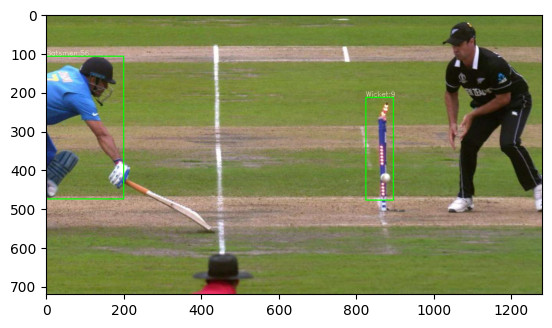

In [6]:
onnx_path = "../../training-jobs/detect/cricket-object-detect17/weights/best.onnx"
# img_path = "../data/Cricket-Semantic-Segmentation[Native]/images/2022-08-24 (13).png"
img_path = "../data/test/ms-dhoni-run-out-in-2019-wc-semi-finals.jpg"

model = ObjectDetectModel(onnx_path)
output = model(img_path)
output.show_image()

In [8]:
if "Batsmen" in output.labels:
    box_id = output.labels.index("Batsmen")
    box = output.boxes[box_id]
    print(box)

[  0 108 200 475]
